In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.jpg')]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label_path = os.path.join(self.label_dir, os.path.basename(img_path).replace('.jpg', '.txt'))
        
        image = Image.open(img_path).convert("RGB")
        boxes = []
        
        with open(label_path, 'r') as file:
            for line in file:
                class_id, x_center, y_center, width, height = map(float, line.split())
                boxes.append([class_id, x_center, y_center, width, height])
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
        
        return image, boxes

In [3]:
from torch.utils.data._utils.collate import default_collate

def collate_fn(batch):
    """
    Custom collate function for handling batches of images with a different number of bounding boxes.
    """
    images = [item[0] for item in batch]  # Extract images
    targets = [item[1] for item in batch]  # Extract targets

    images = default_collate(images)  # Use default collate function to process images
    
    # We don't stack targets into a single tensor because they have varying dimensions
    return images, targets

In [4]:
# Define data augmentation and transformation pipeline
transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor()           # Convert the image to PyTorch tensor
])

# Setup dataset and dataloader
train_data_dir = r'C:\Users\krrah\Downloads\traffic2\data\images\train'
train_label_dir = r'C:\Users\krrah\Downloads\traffic2\data\labels\train'

val_data_dir = r'C:\Users\krrah\Downloads\traffic2\data\images\val'
val_label_dir = r'C:\Users\krrah\Downloads\traffic2\data\labels\val'

train_dataset = YOLODataset(train_data_dir, train_label_dir, transform=transforms)
val_dataset = YOLODataset(val_data_dir, val_label_dir, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

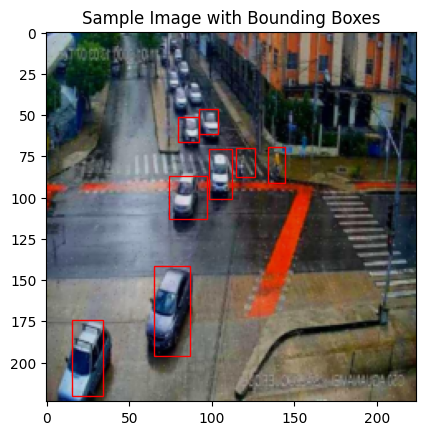

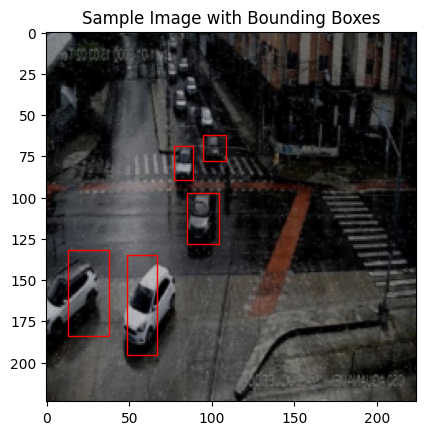

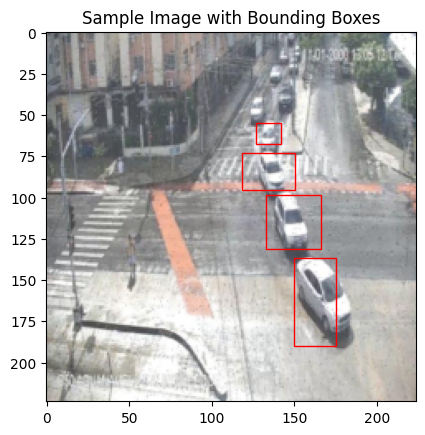

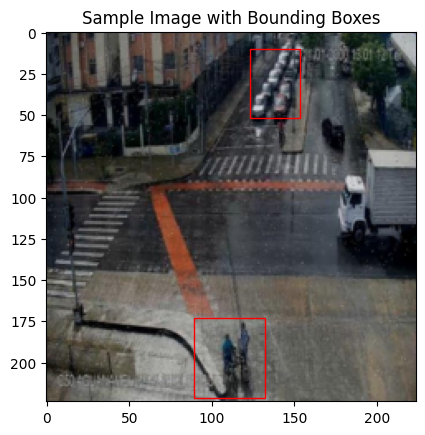

In [5]:
def show_image(img, targets, title=""):
    """Show image with bounding boxes. Handles cases where there may be no bounding boxes."""
    fig, ax = plt.subplots(1)
    ax.imshow(img.permute(1, 2, 0))  # Assume img is a tensor and needs permute
    
    # Check if targets is not None and is a tensor with elements
    if targets is not None and isinstance(targets, torch.Tensor) and targets.numel() > 0:
        for box in targets:
            # Create a rectangle patch
            rect = patches.Rectangle(
                ((box[1] - box[3] / 2) * img.shape[2], (box[2] - box[4] / 2) * img.shape[1]),
                box[3] * img.shape[2],
                box[4] * img.shape[1],
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
    plt.title(title)
    plt.show()

# Test the function with corrected data assumptions
sample_images, sample_targets = next(iter(train_loader))
if sample_images.size(0) > 0:
    # Assumption: Each element in sample_targets is a tensor for corresponding sample image
    for img, targets in zip(sample_images, sample_targets):
        if isinstance(targets, torch.Tensor) and targets.numel() > 0:
            show_image(img, targets, "Sample Image with Bounding Boxes")
        else:
            print("No bounding boxes to display for an image.")
else:
    print("No data to display.")

In [6]:
import sys
sys.path.append(r'C:\path\to\yolov5')

from models.yolo import Model 

ModuleNotFoundError: No module named 'models'

In [ ]:
model_cfg_path = r'C:\Users\krrah\Downloads\traffic2\yolov5s.yaml'  # Update this to the path where you've saved the .yaml file
model_weights_path = r'C:\Users\krrah\Downloads\traffic2\yolov5s.pt'  # Update this to the path where you've saved the .pt file

from models.yolo import Model  # Assuming you've structured your directory or used the Ultralytics repo correctly

# Load a pre-trained YOLOv5s model
model = Model(cfg=model_cfg_path, ch=3, nc=2)  # Adjust `nc` (number of classes) as per your dataset
model.load_state_dict(torch.load(model_weights_path)['model'].state_dict())
model.eval()


ModuleNotFoundError: No module named 'models'

In [ ]:
from torch.optim import Adam

# Optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        # Move data to the appropriate device (e.g., GPU)
        images = images.to('cuda')
        targets = [target.to('cuda') for target in targets]
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss, loss_items = loss_fn(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    # Validation step (if needed)
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            # Similar steps for validation
            pass


TypeError: 'DetectMultiBackend' object is not subscriptable

Training loop